In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 8.4 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=fe8f7a0f3f694994d0d311295d614931ec8ee6dba0b15e520e44af64b1a8d43e
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


In [3]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import xgboost
import six
import sys
import keras
sys.modules['sklearn.externals.six'] = six
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

import dask
import multiprocessing
from joblib import delayed, Parallel, parallel_backend
cores = multiprocessing.cpu_count()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
xml = '/content/drive/MyDrive/Aspect_Based_Sentiment_Analysis/Data/ABSA16_Laptops_Train_SB1_v2.xml'
  

def xml2datadrame(xml):
    dataset = []                                              
    root = et.parse(xml).getroot()  

    for i in root:
      for review in i:
        for sen in review:
          try:
            for txt1 in sen.iter('text'):
              t = txt1.text
            for txt1 in sen.iter('Opinion'):
                category = txt1.attrib["category"]
                polarity = txt1.attrib["polarity"]
                #aspect = txt1.attrib["target"]

                row = {"text": t,"aspect category":category,"polarity":polarity}   
                dataset.append(row)

          except IndexError: 
              row = {"sentence": t}        
              dataset.append(row)  
          
    return pd.DataFrame(dataset)
           

Laptop_df = xml2datadrame(xml)
Laptop_df_new = Laptop_df[Laptop_df['text'].str.contains("\n") == False]
Laptop_df_new.head(10)
#len(Laptop_df_new)

,text,aspect category,polarity
0,This computer is absolutely AMAZING!!!,LAPTOP#GENERAL,positive
1,10 plus hours of battery...,BATTERY#OPERATION_PERFORMANCE,positive
2,super fast processor and really nice graphics ...,CPU#OPERATION_PERFORMANCE,positive
3,super fast processor and really nice graphics ...,GRAPHICS#GENERAL,positive
4,and plenty of storage with 250 gb(though I wil...,HARD_DISC#DESIGN_FEATURES,positive
5,This computer is really fast and I'm shocked a...,LAPTOP#OPERATION_PERFORMANCE,positive
6,This computer is really fast and I'm shocked a...,LAPTOP#USABILITY,positive
7,I've only had mine a day but I'm already used ...,LAPTOP#USABILITY,positive
8,GET THIS COMPUTER FOR PORTABILITY AND FAST PRO...,LAPTOP#PORTABILITY,positive
9,GET THIS COMPUTER FOR PORTABILITY AND FAST PRO...,CPU#OPERATION_PERFORMANCE,positive


In [5]:
xml = '/content/drive/MyDrive/Aspect_Based_Sentiment_Analysis/Data/EN_LAPT_SB1_TEST_.xml'
  
def xml2datadrame(xml):
    dataset = []                                              
    root = et.parse(xml).getroot()  

    for i in root:
      for review in i:
        for sen in review:
          try:
            for txt1 in sen.iter('text'):
              t = txt1.text

            row = {"text": t}   
            dataset.append(row)

          except IndexError: 
              row = {"sentence": t}        
              dataset.append(row)  
          
    return pd.DataFrame(dataset)
           

Laptop_df = xml2datadrame(xml)
test = Laptop_df[Laptop_df['text'].str.contains("\n") == False]
test.head(10)

,text
0,"Well, my first apple computer and I am impressed."
1,"Works well, fast and no reboots."
2,Waiting to install MS Office and see how it go...
3,"Have always been a PC guy, but decided to try ..."
4,Glad I did so far.
5,s.... L .... o..... w.... rea......llllyy slow.
6,like seriously - really slow.
7,impossible to use.
8,cant even read properly.
9,plus - no russian input ?? wtf


In [6]:
test.text[3]

'Have always been a PC guy, but decided to try Apple.'

In [7]:
Laptop_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2909 entries, 0 to 2908
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             2909 non-null   object
 1   aspect category  2909 non-null   object
 2   polarity         2909 non-null   object
dtypes: object(3)
memory usage: 90.9+ KB


In [8]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))

rcParams['figure.figsize'] = 6, 8

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


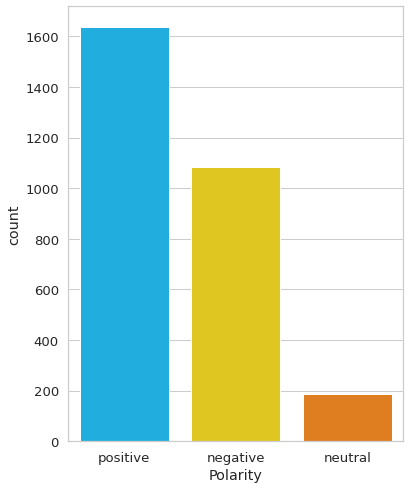

In [9]:
sns.countplot(Laptop_df_new.polarity)
plt.xlabel('Polarity');

In [10]:
#handling categorical value : Converting the polarity into integers-1(Negative), 0(Neutral) and 1(positive) sentiment:
def to_sentiment(rating):
  #rating = int(rating)
  if rating == "positive":
    return 1
  elif rating == "negative":
    return -1
  else: 
    return 0

Laptop_df_new['polarity'] = Laptop_df_new.polarity.apply(to_sentiment)

In [11]:
Laptop_df_new

,text,aspect category,polarity
0,This computer is absolutely AMAZING!!!,LAPTOP#GENERAL,1
1,10 plus hours of battery...,BATTERY#OPERATION_PERFORMANCE,1
2,super fast processor and really nice graphics ...,CPU#OPERATION_PERFORMANCE,1
3,super fast processor and really nice graphics ...,GRAPHICS#GENERAL,1
4,and plenty of storage with 250 gb(though I wil...,HARD_DISC#DESIGN_FEATURES,1
...,...,...,...
2904,"I would recommend it, for anybody needing a re...",LAPTOP#QUALITY,1
2905,I bought this for my daughter to use for schoo...,LAPTOP#OPERATION_PERFORMANCE,0
2906,I bought this for my daughter to use for schoo...,LAPTOP#DESIGN_FEATURES,1
2907,I bought this for my daughter to use for schoo...,LAPTOP#GENERAL,1


In [12]:
Laptop_df_new['aspect category'].value_counts()

LAPTOP#GENERAL                  634
LAPTOP#OPERATION_PERFORMANCE    278
LAPTOP#DESIGN_FEATURES          253
LAPTOP#QUALITY                  224
LAPTOP#MISCELLANEOUS            142
                               ... 
FANS_COOLING#DESIGN_FEATURES      1
SOFTWARE#PRICE                    1
CPU#MISCELLANEOUS                 1
PORTS#DESIGN_FEATURES             1
CPU#DESIGN_FEATURES               1
Name: aspect category, Length: 81, dtype: int64

In [13]:
# Get the count of each value
value_counts = Laptop_df_new['aspect category'].value_counts()

# Select the values where the count is less than 3 (or 5 if you like)
to_remove = value_counts[value_counts <= 50].index

# Keep rows where the city column is not in to_remove
Laptop_df_new = Laptop_df_new[~Laptop_df_new['aspect category'].isin(to_remove)]

In [14]:
Laptop_df_new.shape

(2281, 3)

In [15]:
Laptop_df_new['aspect category'].value_counts()

LAPTOP#GENERAL                   634
LAPTOP#OPERATION_PERFORMANCE     278
LAPTOP#DESIGN_FEATURES           253
LAPTOP#QUALITY                   224
LAPTOP#MISCELLANEOUS             142
LAPTOP#USABILITY                 141
SUPPORT#QUALITY                  138
LAPTOP#PRICE                     136
COMPANY#GENERAL                   90
BATTERY#OPERATION_PERFORMANCE     86
LAPTOP#CONNECTIVITY               55
DISPLAY#QUALITY                   53
LAPTOP#PORTABILITY                51
Name: aspect category, dtype: int64

In [16]:
#Drop Nan Values
Laptop_df_new=Laptop_df_new.dropna()
#Checking for null values
Laptop_df_new.isnull().sum()

text               0
aspect category    0
polarity           0
dtype: int64

In [17]:
data=Laptop_df_new

In [18]:
data_text=data['text'].tolist()

In [19]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [20]:
data['cleaned_text']= data['text'].apply((lambda x: clean(x))) 
data

,text,aspect category,polarity,cleaned_text
0,This computer is absolutely AMAZING!!!,LAPTOP#GENERAL,1,computer absolutely amazing
1,10 plus hours of battery...,BATTERY#OPERATION_PERFORMANCE,1,10 plus hours battery
5,This computer is really fast and I'm shocked a...,LAPTOP#OPERATION_PERFORMANCE,1,computer really fast shocked easy get used
6,This computer is really fast and I'm shocked a...,LAPTOP#USABILITY,1,computer really fast shocked easy get used
7,I've only had mine a day but I'm already used ...,LAPTOP#USABILITY,1,mine day already used
...,...,...,...,...
2904,"I would recommend it, for anybody needing a re...",LAPTOP#QUALITY,1,would recommend anybody needing reliable simpl...
2905,I bought this for my daughter to use for schoo...,LAPTOP#OPERATION_PERFORMANCE,0,bought daughter use school homework fast compu...
2906,I bought this for my daughter to use for schoo...,LAPTOP#DESIGN_FEATURES,1,bought daughter use school homework fast compu...
2907,I bought this for my daughter to use for schoo...,LAPTOP#GENERAL,1,bought daughter use school homework fast compu...


In [21]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(data['cleaned_text'])
xtrain_tfidf =  tfidf_vect.transform(data['cleaned_text'])

In [22]:
#oversampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(xtrain_tfidf, data['aspect category'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)

    print(classification_report(predictions, test_y))

    cmat = confusion_matrix(predictions, test_y)
    plt.figure(figsize=(16,7))
    sns.set(font_scale = 1.4)
    sns.heatmap(cmat, annot = True, cbar = False, cmap=plt.cm.Greens, fmt="d",linewidths=0.2);
    class_names = ['LAPTOP#GENERAL','LAPTOP#OPERATION_PERFORMANCE' ,'LAPTOP#DESIGN_FEATURES ',
                  'LAPTOP#QUALITY', 'LAPTOP#MISCELLANEOUS', 'LAPTOP#USABILITY' ,
                  'SUPPORT#QUALITY' ,'LAPTOP#PRICE' ,'COMPANY#GENERAL','BATTERY#OPERATION_PERFORMANCE',
                  'LAPTOP#CONNECTIVITY','DISPLAY#QUALITY' ,'LAPTOP#PORTABILITY']

    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return metrics.accuracy_score(predictions, test_y),classifier

Aspect Category Classifier

                               precision    recall  f1-score   support

BATTERY#OPERATION_PERFORMANCE       0.94      0.87      0.91        78
              COMPANY#GENERAL       0.98      0.82      0.90        68
              DISPLAY#QUALITY       1.00      0.79      0.88        66
          LAPTOP#CONNECTIVITY       0.96      0.94      0.95        72
       LAPTOP#DESIGN_FEATURES       0.59      0.86      0.70        50
               LAPTOP#GENERAL       0.33      0.69      0.44        29
         LAPTOP#MISCELLANEOUS       0.89      0.84      0.86        57
 LAPTOP#OPERATION_PERFORMANCE       0.61      0.88      0.72        50
           LAPTOP#PORTABILITY       0.99      0.88      0.93        91
                 LAPTOP#PRICE       0.89      0.72      0.79        81
               LAPTOP#QUALITY       0.67      0.78      0.72        49
             LAPTOP#USABILITY       0.88      0.74      0.80        61
              SUPPORT#QUALITY       0.95      0.77      0.85        73

    

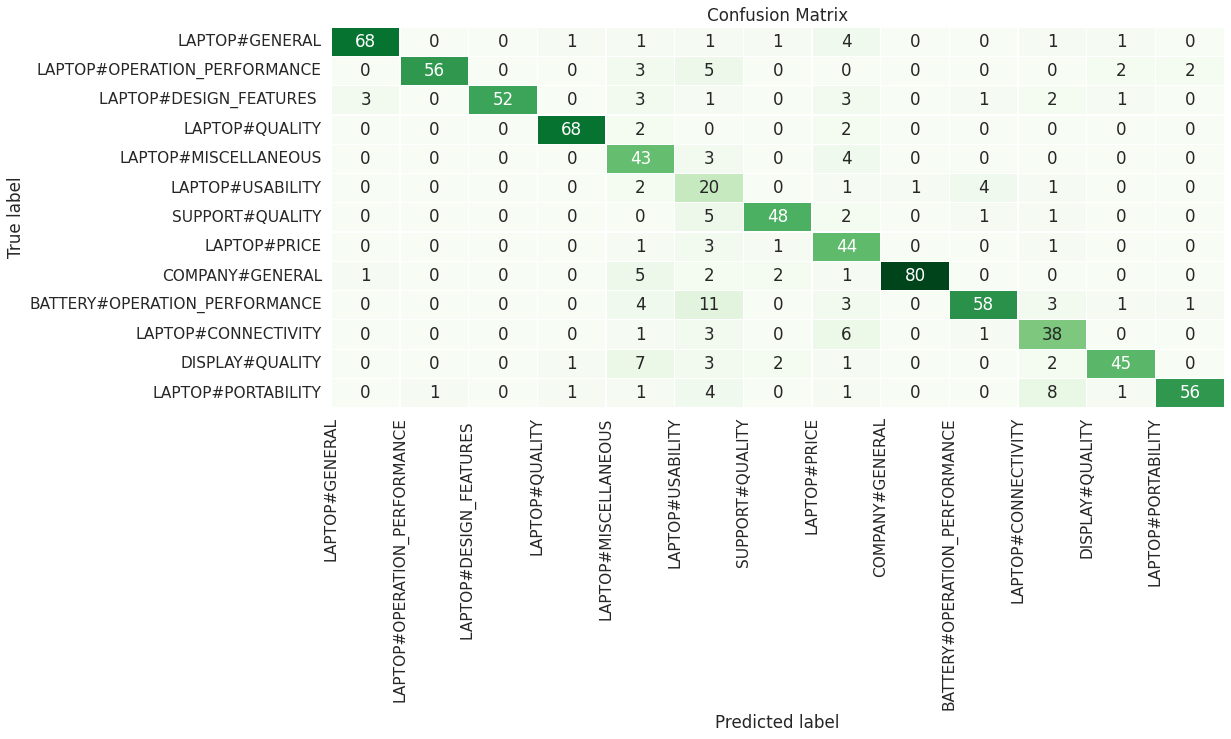

In [25]:
# Naive Bayes
accuracy,classifier_nb = train_model(naive_bayes.MultinomialNB(), X_train, y_train, X_test, y_test)
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

                               precision    recall  f1-score   support

BATTERY#OPERATION_PERFORMANCE       0.94      0.92      0.93        74
              COMPANY#GENERAL       0.98      0.85      0.91        66
              DISPLAY#QUALITY       1.00      0.87      0.93        60
          LAPTOP#CONNECTIVITY       0.97      0.97      0.97        71
       LAPTOP#DESIGN_FEATURES       0.71      0.79      0.75        66
               LAPTOP#GENERAL       0.48      0.64      0.55        45
         LAPTOP#MISCELLANEOUS       0.89      0.86      0.87        56
 LAPTOP#OPERATION_PERFORMANCE       0.72      0.87      0.79        60
           LAPTOP#PORTABILITY       0.99      0.95      0.97        84
                 LAPTOP#PRICE       0.80      0.78      0.79        67
               LAPTOP#QUALITY       0.74      0.78      0.76        54
             LAPTOP#USABILITY       0.88      0.82      0.85        55
              SUPPORT#QUALITY       0.95      0.84      0.89        67

    

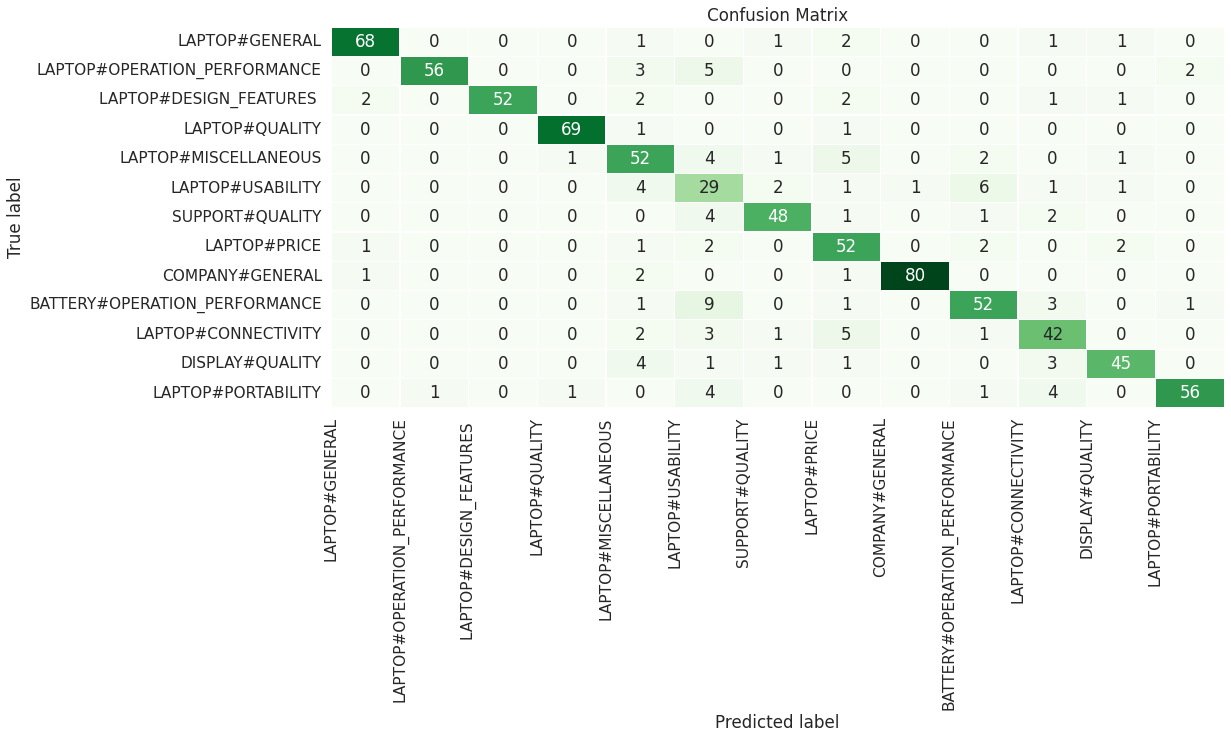

In [26]:
# Linear Classifier
accuracy,classifier_lg = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), X_train, y_train, X_test, y_test)
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

                               precision    recall  f1-score   support

BATTERY#OPERATION_PERFORMANCE       0.90      0.92      0.91        71
              COMPANY#GENERAL       0.88      0.88      0.88        57
              DISPLAY#QUALITY       0.98      0.93      0.95        55
          LAPTOP#CONNECTIVITY       0.92      0.92      0.92        71
       LAPTOP#DESIGN_FEATURES       0.55      0.71      0.62        56
               LAPTOP#GENERAL       0.46      0.33      0.38        85
         LAPTOP#MISCELLANEOUS       0.87      0.85      0.86        55
 LAPTOP#OPERATION_PERFORMANCE       0.60      0.70      0.65        61
           LAPTOP#PORTABILITY       0.91      0.96      0.94        77
                 LAPTOP#PRICE       0.69      0.73      0.71        62
               LAPTOP#QUALITY       0.65      0.69      0.67        54
             LAPTOP#USABILITY       0.78      0.71      0.75        56
              SUPPORT#QUALITY       0.97      0.88      0.92        65

    

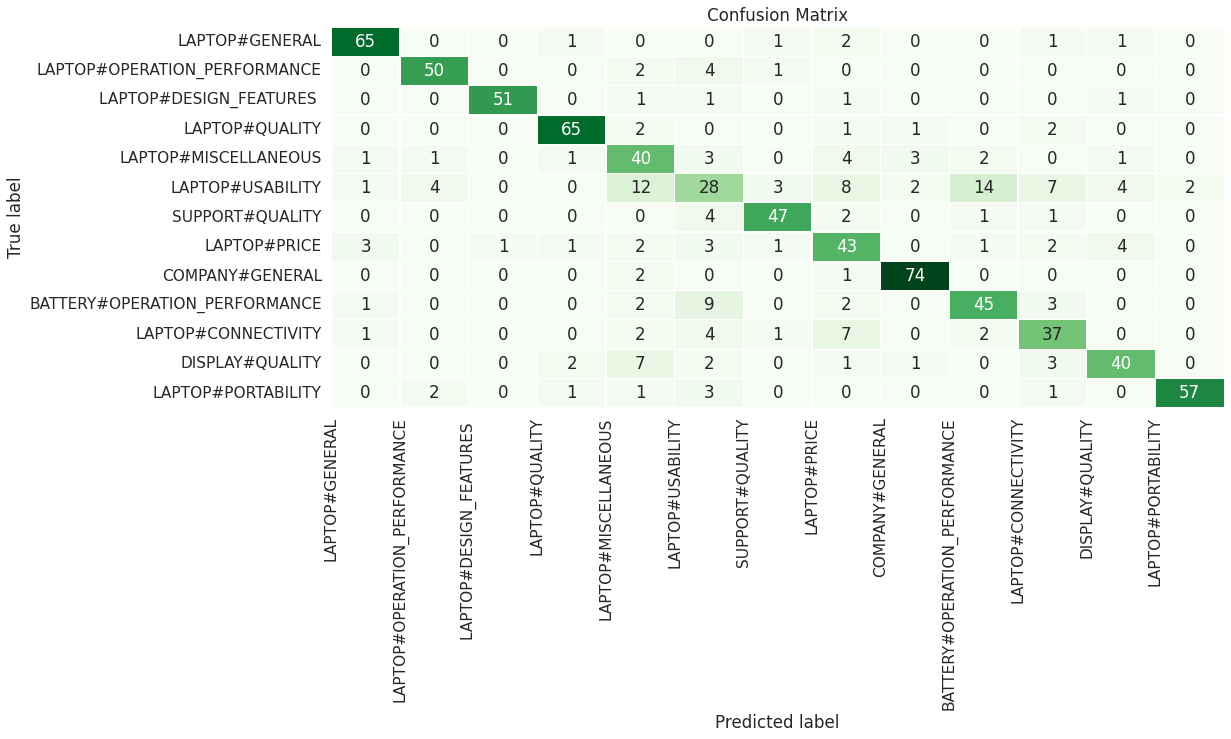

In [27]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
accuracy,classifier_rf = train_model(RandomForestClassifier(), X_train, y_train, X_test, y_test)
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

Polarity

In [28]:
#oversampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_p, y_p = oversample.fit_resample(xtrain_tfidf, data['polarity'])

In [29]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p,test_size=0.1)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)

    print(classification_report(predictions, test_y))

    cmat = confusion_matrix(predictions, test_y)
    plt.figure(figsize=(6,6))
    sns.set(font_scale = 1.4)
    sns.heatmap(cmat, annot = True, cbar = False, cmap=plt.cm.Greens, fmt="d",linewidths=0.2);
    class_names = ['Positive','Negative' ,'Neutral ']

    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return metrics.accuracy_score(predictions, test_y),classifier

              precision    recall  f1-score   support

          -1       0.83      0.82      0.82       130
           0       1.00      0.77      0.87       159
           1       0.67      0.90      0.77       119

    accuracy                           0.82       408
   macro avg       0.84      0.83      0.82       408
weighted avg       0.85      0.82      0.83       408

-> WordLevel TF-IDF Accuracy: 82.11%


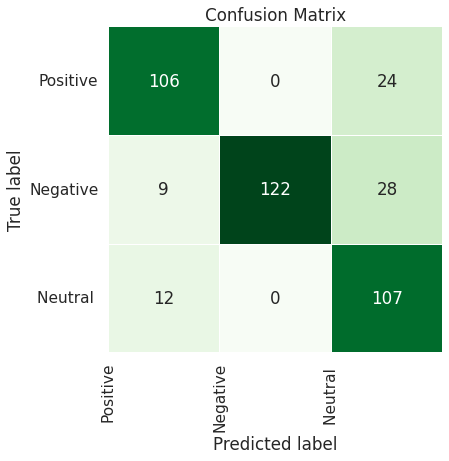

In [31]:
# Naive Bayes
accuracy,classifier_nb_p = train_model(naive_bayes.MultinomialNB(), X_train_p, y_train_p, X_test_p, y_test_p)
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

              precision    recall  f1-score   support

          -1       0.90      0.79      0.84       144
           0       0.98      0.85      0.91       141
           1       0.70      0.91      0.79       123

    accuracy                           0.85       408
   macro avg       0.86      0.85      0.85       408
weighted avg       0.87      0.85      0.85       408

-> WordLevel TF-IDF Accuracy: 84.8%


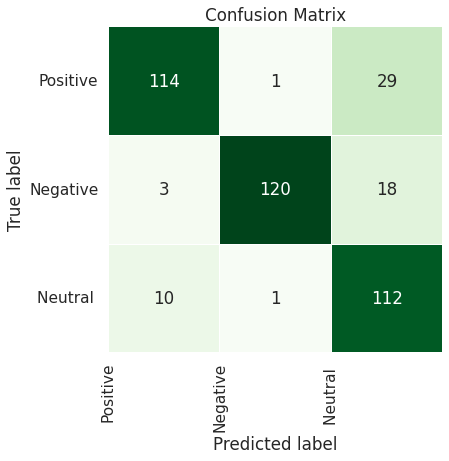

In [32]:
# Linear Classifier
accuracy,classifier_lg_p = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), X_train_p, y_train_p, X_test_p, y_test_p)
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

              precision    recall  f1-score   support

          -1       0.91      0.73      0.81       157
           0       0.93      0.92      0.93       124
           1       0.70      0.87      0.78       127

    accuracy                           0.83       408
   macro avg       0.85      0.84      0.84       408
weighted avg       0.85      0.83      0.83       408

-> WordLevel TF-IDF Accuracy: 83.33%


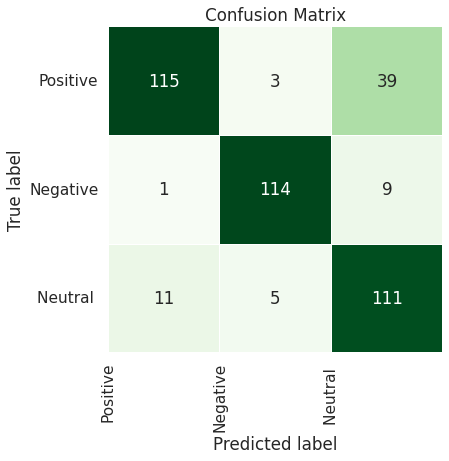

In [33]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
accuracy,classifier_rf_p = train_model(RandomForestClassifier(), X_train_p, y_train_p, X_test_p, y_test_p)
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

Testing

In [34]:
def test_aspect_sentiment(text):
  df = pd.DataFrame(text,columns=['text'])
  text1 = df['text'].apply((lambda x: clean(x)))
  #print(text1.tolist()) 
  xtesting_tfidf =  tfidf_vect.transform(text1)
  ac = classifier_lg.predict(xtesting_tfidf)
  pol = classifier_lg_p.predict(xtesting_tfidf)
  #print(ac,pol)
  pol1 = []
  for i in pol:
    if i == 1:
      pol1.append("positive")
    elif i == -1:
      pol1.append("negative")
    else: 
      pol1.append("netural")
  df1 = pd.DataFrame({'text':text1,'aspect_category':ac,'polarity':pol1})
  print(df1)


In [35]:
text = ['Well, my first apple computer and I am impressed','Have always been a PC guy, but decided to try Apple','cant even read properly']
test_aspect_sentiment(text)

                                  text  aspect_category  polarity
0  well first apple computer impressed   LAPTOP#QUALITY  positive
1      always pc guy decided try apple  COMPANY#GENERAL  positive
2              cant even read properly  SUPPORT#QUALITY  negative
